In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import joblib
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/kaggle/input/optimization-of-machine-downtime/Machine Downtime.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             2500 non-null   object 
 1   Machine_ID                       2500 non-null   object 
 2   Assembly_Line_No                 2500 non-null   object 
 3   Hydraulic_Pressure(bar)          2490 non-null   float64
 4   Coolant_Pressure(bar)            2481 non-null   float64
 5   Air_System_Pressure(bar)         2483 non-null   float64
 6   Coolant_Temperature              2488 non-null   float64
 7   Hydraulic_Oil_Temperature(?C)    2484 non-null   float64
 8   Spindle_Bearing_Temperature(?C)  2493 non-null   float64
 9   Spindle_Vibration(?m)            2489 non-null   float64
 10  Tool_Vibration(?m)               2489 non-null   float64
 11  Spindle_Speed(RPM)               2494 non-null   float64
 12  Voltage(volts)      

In [5]:
df["Downtime"].value_counts()

Downtime
Machine_Failure       1265
No_Machine_Failure    1235
Name: count, dtype: int64

# Exploratory Data Analysis

In [6]:
numerical=["Hydraulic_Pressure(bar)","Coolant_Pressure(bar)",
           "Air_System_Pressure(bar)","Coolant_Temperature",
           "Hydraulic_Oil_Temperature(?C)","Spindle_Bearing_Temperature(?C)",
           "Spindle_Vibration(?m)","Tool_Vibration(?m)",
           "Spindle_Speed(RPM)","Voltage(volts)","Torque(Nm)",
           "Cutting(kN)"]
categorical=["Machine_ID","Assembly_Line_No","Downtime"]

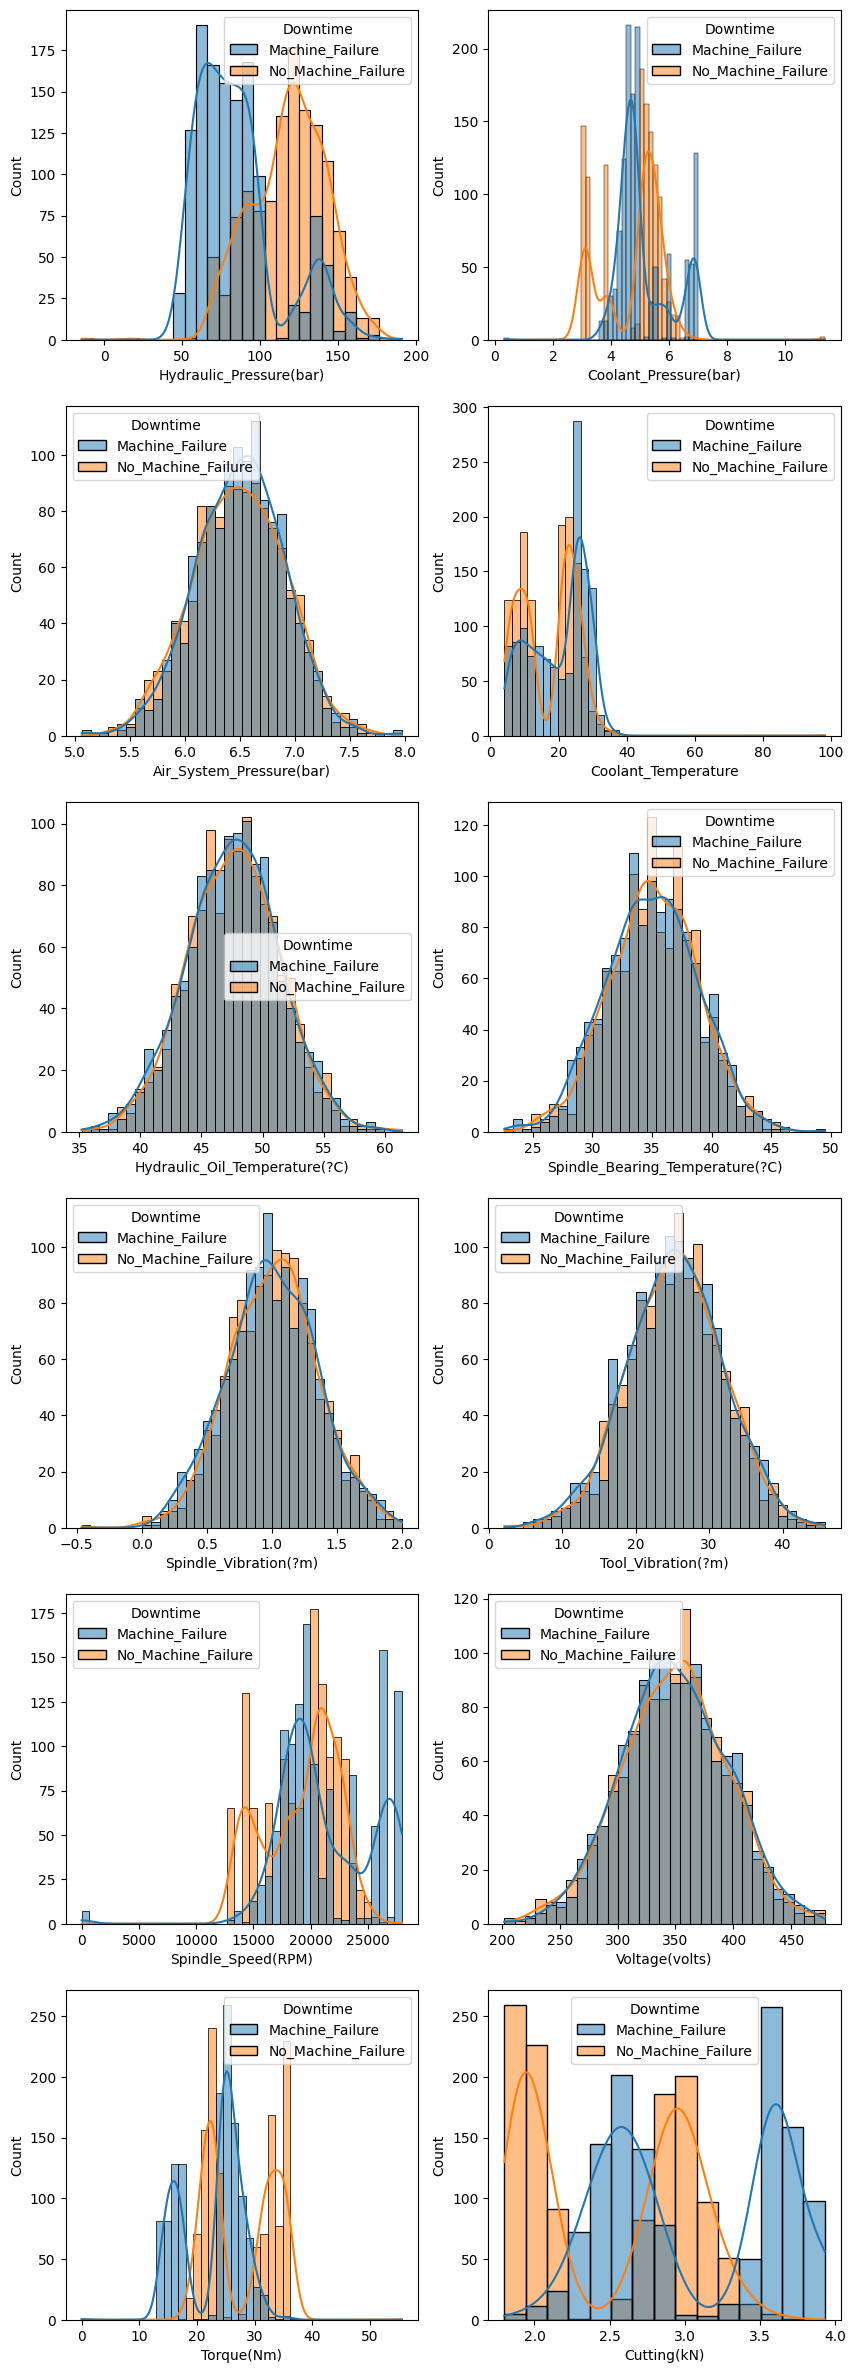

In [7]:
fig,axes=plt.subplots(6,2,figsize=(10,30))
ax=axes.flatten()

for i,feature in enumerate(numerical):
    sns.histplot(x=feature,hue="Downtime",data=df,ax=ax[i],kde=True);

In [8]:
downtime_label_mapping={"No_Machine_Failure":0,
                        "Machine_Failure":1}

df["Downtime_temp"]=df["Downtime"].map(downtime_label_mapping)

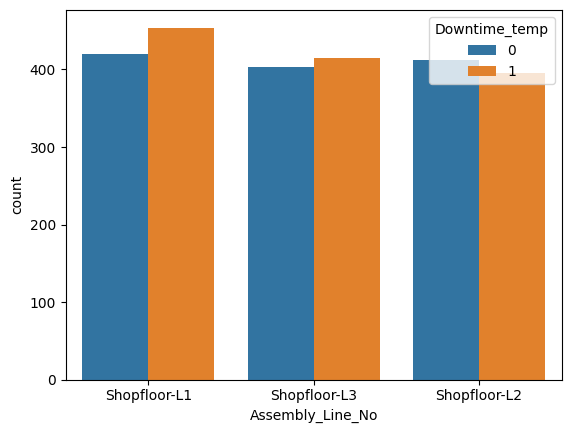

In [9]:
sns.countplot(x="Assembly_Line_No",hue="Downtime_temp",data=df);

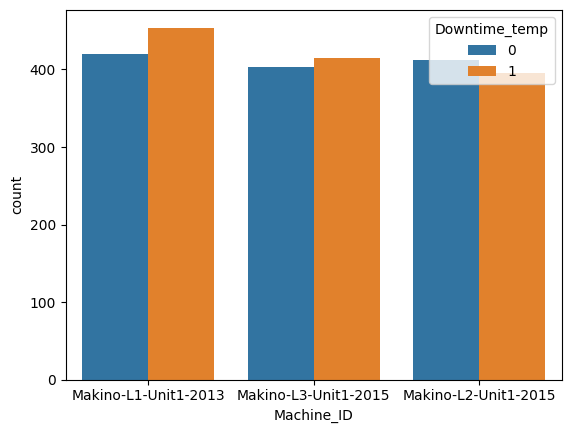

In [10]:
sns.countplot(x="Machine_ID",hue="Downtime_temp",data=df);

# Feature Selection

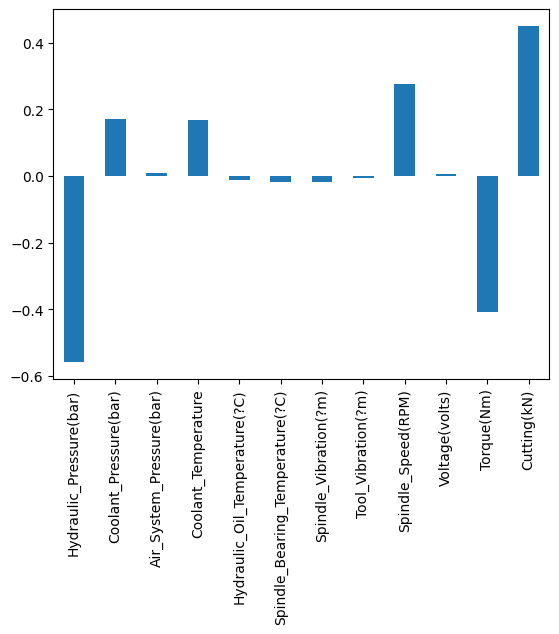

In [11]:
columns=numerical+["Downtime_temp"]
ser=df[columns].corr()["Downtime_temp"]
ser[:-1].plot(kind="bar");

In [12]:
variables=["Assembly_Line_No","Machine_ID"]
indexs={"Assembly_Line_No":["Shopfloor-L1","Shopfloor-L2","Shopfloor-L3"],
        "Machine_ID":["Makino-L1-Unit1-2013","Makino-L2-Unit1-2015",
                      "Makino-L3-Unit1-2015"]}

for var in variables:
    inter=df.groupby(var)[["Downtime_temp"]].agg(['sum','count'])
    Machine_Failure=inter['Downtime_temp']['sum'].values
    No_Machine_Failure=(inter['Downtime_temp']['count']-inter['Downtime_temp']['sum']).values
    
    contingency_table=pd.DataFrame({"No_Machine_Failure":No_Machine_Failure,
                                    "Machine_Failure":Machine_Failure},
                                    index=indexs[var])
    
    stat, p, dof, expected = chi2_contingency(contingency_table)
    
    expected_table=pd.DataFrame(expected,columns=["No_Machine_Failure","Machine_Failure"],
                                index=indexs[var])
    
    print(var,'\n\nObserved Table\n',contingency_table,'\n\nExpected Table\n',expected_table)
    
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('\nProbability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject Null Hypothesis)')
    else:
        print('Independent (fail to reject Null Hypothesis)')
    print("*"*50)

Assembly_Line_No 

Observed Table
               No_Machine_Failure  Machine_Failure
Shopfloor-L1                 420              454
Shopfloor-L2                 412              396
Shopfloor-L3                 403              415 

Expected Table
               No_Machine_Failure  Machine_Failure
Shopfloor-L1             431.756          442.244
Shopfloor-L2             399.152          408.848
Shopfloor-L3             404.092          413.908

Probability=0.950, critical=5.991, stat=1.456
Independent (fail to reject Null Hypothesis)
**************************************************
Machine_ID 

Observed Table
                       No_Machine_Failure  Machine_Failure
Makino-L1-Unit1-2013                 420              454
Makino-L2-Unit1-2015                 412              396
Makino-L3-Unit1-2015                 403              415 

Expected Table
                       No_Machine_Failure  Machine_Failure
Makino-L1-Unit1-2013             431.756          442.244
Makino-L2

# Data Preprocessing

In [13]:
features=["Hydraulic_Pressure(bar)","Coolant_Pressure(bar)",
         "Air_System_Pressure(bar)","Coolant_Temperature",
         "Hydraulic_Oil_Temperature(?C)","Spindle_Bearing_Temperature(?C)",
         "Spindle_Vibration(?m)","Tool_Vibration(?m)",
         "Spindle_Speed(RPM)","Voltage(volts)","Torque(Nm)",
         "Cutting(kN)"]

In [14]:
def preprocess_dataset(df,features):
    print(f"No of features: {len(features)}")
    dataframe=df.copy()
    dataframe=dataframe[features+["Downtime"]]
    dataframe.dropna(inplace=True,ignore_index=True)
    X=dataframe[features]
    y=dataframe["Downtime"]
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,
                                                   random_state=42,stratify=y)
    transform=PowerTransformer()
    X_train=transform.fit_transform(X_train)
    X_test=transform.transform(X_test)
    
    encoder=LabelEncoder()
    y_train=encoder.fit_transform(y_train)
    y_test=encoder.transform(y_test)
    return X_train,X_test,y_train,y_test

In [15]:
X_train,X_test,y_train,y_test=preprocess_dataset(df,features)

No of features: 12


# Modelling

In [16]:
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
predict=model.predict(X_test)

In [17]:
print(f"Accuracy :{accuracy_score(y_test,predict)}")
print(f"F1_Score :{f1_score(y_test,predict)}")

Accuracy :0.9874213836477987
F1_Score :0.9871244635193133


# Feature Importance

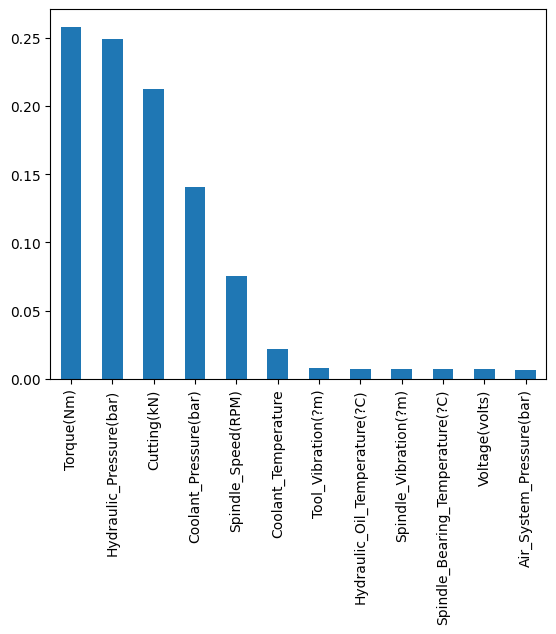

In [18]:
inter=pd.Series(data=model.feature_importances_,index=features)
inter.sort_values(inplace=True,ascending=False)
inter.plot(kind="bar");

In [19]:
features=["Torque(Nm)","Hydraulic_Pressure(bar)","Cutting(kN)",
          "Coolant_Pressure(bar)","Spindle_Speed(RPM)","Coolant_Temperature"]

In [20]:
X_train,X_test,y_train,y_test=preprocess_dataset(df,features)

No of features: 6


In [21]:
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
predict=model.predict(X_test)

In [22]:
print(f"Accuracy :{accuracy_score(y_test,predict)}")
print(f"F1_Score :{f1_score(y_test,predict)}")

Accuracy :0.9897750511247444
F1_Score :0.9896049896049895


# Model Evaluation

In [23]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       251
           1       0.98      1.00      0.99       238

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



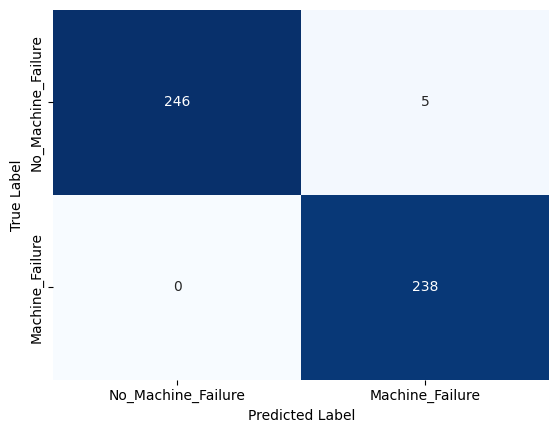

In [24]:
labels=["No_Machine_Failure","Machine_Failure"]
results=pd.DataFrame(confusion_matrix(y_test,predict),columns=labels,
                     index=labels)
sns.heatmap(results,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');

In [25]:
joblib.dump(model,"model.pkl")

['model.pkl']